In [1]:
import os
import math

import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import random

In [2]:
#global variables
maxT = 37
maxLambda = 800
PAD_VALUE = -1
NEvts = 1000
pi = 3.141592653589793

In [3]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences

class MyGenerator(Sequence):
    def __init__(self, x_dir, batch_size):
        self.x_dir = x_dir
        self.x = os.listdir(x_dir)
        self.batch_size = batch_size
        print('Generator init complete')
        
    def __len__(self):
        nf = self.batch_size/(NEvts) # calculate number of files
        return math.ceil(len(self.x) / nf)

    def __getitem__(self, idx):
        batch_data = np.load(os.path.join(self.x_dir, self.x[idx]))
        Y = np.array(batch_data['y_vtx'])
        return np.array(batch_data['x']), Y

In [4]:
training_generator = MyGenerator('/data/Elagin/vtx_dir_1el_norm', NEvts)

testing_generator = MyGenerator('/data/Elagin/test_vtx_dir_1el_norm', NEvts)

Generator init complete
Generator init complete


In [5]:

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda, Input, Concatenate, concatenate
from keras.layers import Conv1D, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling1D, MaxPooling2D, LocallyConnected2D, LocallyConnected1D
from keras.layers import LSTM, Bidirectional
from keras.layers import Masking
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import keras.backend as K

In [6]:
def mapping_to_pmOne(x) :
    return 2*K.sigmoid(x) - 1

def mapping_to_pm50(x) :
    return mapping_to_pmOne(x)*50

def mapping_to_pm300(x) :
    return mapping_to_pmOne(x)*300

def mapping_to_0_50(x) :
    return 50*K.sigmoid(x)


def mapping_to_target_range_all( x, target_min=-0.02*pi, target_max=2.02*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

def mapping_to_target_range_2pi( x, target_min=-0.00*pi, target_max=2.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_pi( x, target_min=-0.00*pi, target_max=1.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_phi( x, target_min=0, target_max=2*pi ) :
    print('is x keras tensor:', K.is_keras_tensor(x))
    print('x shape = ',K.int_shape(x))
    print('x shape = ',K.shape(x))
    #phi = K.placeholder(shape=(None,1))
    phi = Input([1])
    #theta = K.placeholder(shape=(None,1))
    theta = Input([1])
    #r = K.placeholder(shape=(None,1))
    r = Input([1])
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    phi = K.concatenate([phi, [K.tanh(x[:,1]) + 1]], axis=0) # x in range(0,2)
    #phi = K.tanh(x[:,1]) + 1
    theta = K.concatenate([theta, [x[:,0]]], axis=0)
    #theta = x[:,0]
    r = K.concatenate([r, [x[:,2]]], axis=0)
    #r = x[:,2]
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    print('theta shape = ',K.int_shape(theta))
    print('r shape = ',K.int_shape(r))
    scale = ( target_max-target_min )/2.
    phi =  phi * scale + target_min
    #phi = K.cast(phi, dtype='int32')
    #phi = K.reshape(phi, (,1))
    print('phi shape = ',K.int_shape(phi))
    
    res = K.concatenate([theta, phi, r], axis=1)
    print('res shape = ',K.int_shape(res))
    print('res shape = ',K.shape(res))
    print('is res keras tensor:', K.is_keras_tensor(res))
    x[:,1].assign(phi)
    return x

def mapping_to_target_range_phi2( x, target_min=0, target_max=2*pi ) :
    scale = ( target_max-target_min )/2.
    phi = K.placeholder(shape=(None,1))
    #phi = Input([1])
    #phi = (K.tanh(x[:,1]) + 1)*scale + target_min
    phi = K.concatenate([phi, [(K.tanh(x[:,1]) + 1)*scale + target_min]], axis=0)
    x[:,1].assign(phi)
    return x

In [10]:
def createModel():
    model = Sequential()
    #model.add(Reshape(input_shape=(3300,), target_shape=(3300,)))
    #model.add(Masking(mask_value=-1,input_shape=(3300,)))
    #model.add(Dense(1024, activation='relu' ))
    #model.add(Dropout(0.1))
    #model.add(Dense(1024, activation='relu' ))
    #model.add(Dropout(0.1))
    #model.add(Dense(512, activation='relu' ))
    #model.add(Dropout(0.1))
    #model.add(Dense(1024, activation='relu' ))
    #model.add(Dropout(0.5))
    #model.add(Dense(512, activation='relu' ))
    #model.add(Dropout(0.1))
    #model.add(Dense(256, activation='relu',input_shape=(3300,) ))
    model.add(Reshape(input_shape=(2100,), target_shape=(2100,1)))
    model.add(LocallyConnected1D(1, 3, strides=3)) #h=7, w=5
    #model.add(Conv1D(1, 3, strides=3)) #h=7, w=5
    model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=3, strides=3)) #h = 24, w = 2
    #model.add(Dropout(0.10))

    #model.add(LocallyConnected1D(64, 50, strides=25, padding='valid')) #h=7, w=5
    #model.add(Conv1D(64, 150, strides=75)) #h=7, w=5
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=2, strides=2)) #h = 24, w = 2
    
    model.add(Flatten())
    #model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.05))
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.1))
    
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.1))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    
    model.add(Dense(3, activation=mapping_to_pm300))
    #model.add(Dense(3, activation=None))
     
    return model

In [7]:
def createModel():
    model = Sequential()
    #model.add(Reshape(input_shape=(3300,), target_shape=(3300,)))
    #model.add(Masking(mask_value=-1))
    model.add(Dense(512, activation='relu',input_shape=(6300,) ))
    #model.add(Reshape(input_shape=(600,), target_shape=(600,1)))
    #model.add(LocallyConnected1D(32, 3, strides=3)) #h=7, w=5
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 1),strides=(1,1))) #h = 24, w = 2
    #model.add(Dropout(0.4))

    #model.add(Flatten())
    #model.add(Dense(1100, activation='relu'))
    #model.add(Dropout(0.3))
    
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.2))
    
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(3, activation=mapping_to_pm300))
    #model.add(Dense(5))#, activation=mapping_to_target_range_phi))
    #model.add(Dense(1, activation='sigmoid'))
    #model.add(Lambda(lambda x: 2*pi*x))
     
    return model

In [15]:
def createModel():
    #model = Sequential()
    in_put = Input(shape=(3300,))
    print('is in_put keras tensor:', K.is_keras_tensor(in_put))
    print('in_put shape = ',K.int_shape(in_put))
    print('in_put shape = ',K.shape(in_put))
    print('\n')
    #layer1 = Dense(2048, activation='relu')(in_put)
    layer2 = Dense(1024, activation='relu')(in_put)
    layer2 = Dropout(0.05)(layer2)
    layer3 = Dense(512, activation='relu')(layer2)
    layer3 = Dropout(0.03)(layer3)
    layer4 = Dense(64, activation='relu')(layer3)
    layer4 = Dropout(0.03)(layer4)
    out_put = Dense(5, activation=None)(layer4)
    print('is out_put keras tensor:', K.is_keras_tensor(out_put))
    print('out_put shape = ',K.int_shape(out_put))
    print('out_put shape = ',K.shape(out_put))
    print('\n')
    #out_put_a = Activation(activation=mapping_to_target_range_phi2)(out_put)
    #out_put= Dense(3, activation=mapping_to_target_range_phi)(layer3) 
    #print('is out_put_a keras tensor:', K.is_keras_tensor(out_put_a))
    #print('out_put_a shape = ',K.int_shape(out_put_a))
    #print('out_put_a shape = ',K.shape(out_put_a))
    #print('\n')
    sinT = Lambda(lambda x: x[:,0], output_shape=(1,))(out_put)
    sinT = Activation(activation='sigmoid')(sinT)
    cosT = Lambda(lambda x: x[:,1], output_shape=(1,))(out_put)
    cosT = Activation(activation=mapping_to_pmOne)(cosT)
    
    sinP = Lambda(lambda x: x[:,2], output_shape=(1,))(out_put)
    sinP = Activation(activation=mapping_to_pmOne)(sinP)
    cosP = Lambda(lambda x: x[:,3], output_shape=(1,))(out_put)
    cosP = Activation(activation=mapping_to_pmOne)(cosP)
   
    r = Lambda(lambda x: x[:,4], output_shape=(1,))(out_put)
    cosP = Activation(activation=mapping_to_0_50)(r)

    print('sinP shape = ',K.int_shape(sinP))
    print('is sinP keras tensor:', K.is_keras_tensor(sinP))
    print('r shape = ',K.int_shape(r))
    out_put_a = Lambda(lambda x: K.stack([x[0], x[1], x[2], x[3], x[4]], axis=1),output_shape=(5,),  name="output")([sinT, cosT, sinP, cosP, r])
    print('is out_put_a keras tensor:', K.is_keras_tensor(out_put_a))
    print('out_put_a shape = ',K.int_shape(out_put_a))
    print('out_put_a shape = ',K.shape(out_put_a))
    #print('\n')
    #out_put= Dense(3, activation=None)(layer3) 
    #model.add(Dense(1, activation='sigmoid'))
    #model.add(Lambda(lambda x: 2*pi*x))
    model = Model(inputs=in_put, outputs=out_put_a)
    return model

In [36]:
def createModel():
    #model = Sequential()
    in_put = Input(shape=(2100,))
    print('is in_put keras tensor:', K.is_keras_tensor(in_put))
    print('in_put shape = ',K.int_shape(in_put))
    print('in_put shape = ',K.shape(in_put))
    print('\n')
    #layer0 = Dense(1024, activation='relu')(in_put)
    #layer0 = Dropout(0.15)(layer0)
    layer1 = Dense(64, activation='relu')(in_put)#(layer0)
    layer1 = Dropout(0.01)(layer1)
    layer2 = Dense(32, activation='relu')(layer1)
    #layer2 = Dropout(0.05)(layer2)
    layer3 = Dense(32, activation='relu')(layer2)
    #layer3 = Dropout(0.04)(layer3)
    out_put = Dense(3)(layer3)
    print('is out_put keras tensor:', K.is_keras_tensor(out_put))
    print('out_put shape = ',K.int_shape(out_put))
    print('out_put shape = ',K.shape(out_put))
    print('\n')
    model = Model(inputs=in_put, outputs=out_put)
    return model

In [6]:
def createModel():
    N=6300
    lstm_seq = 300
    lstm_steps = int(N/lstm_seq)
    model = Sequential()
    
    #model.add(Reshape(input_shape=(3300,), target_shape=(3300,1)))
    
    #model.add(Conv1D(32, 60, strides=15)) #h=7, w=5
    
    #lstm_steps = 216
    #lstm_seq = 32
    
    #model.add(Reshape(input_shape=(N,), target_shape=(60,int(N/60))))
    model.add(Reshape(input_shape=(N,), target_shape=(lstm_steps,lstm_seq)))
    #model.add(Reshape(input_shape=(N,), target_shape=(1,N)))
    
    model.add(Masking(mask_value=-1, input_shape=(lstm_steps, lstm_seq)))
    
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    
    #model.add(LSTM(1, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    #model.add(LSTM(1, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    
    #model.add(Bidirectional(LSTM(4, return_sequences=True, dropout=0.0)))
    #model.add(Bidirectional(LSTM(8, return_sequences=True, dropout=0.0)))
    #model.add(Bidirectional(LSTM(1, dropout=0.0)))
    
    
    #model.add(LSTM(1, return_sequences=True, input_shape=(3, int(N/3)), dropout=0.5))
    #model.add(LSTM(1, return_sequences=True, dropout=0.5))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    #model.add(Dense(3, activation=mapping_to_pm300))
    model.add(Dense(3, activation=None))
    
    return model

In [7]:
my_network=createModel()

In [8]:
my_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 21, 300)           0         
_________________________________________________________________
masking (Masking)            (None, 21, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 75)            112800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 75)            45300     
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 75)            45300     
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 75)            45300     
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 75)            4

In [ ]:
batch_size = NEvts
epochs = 200

def mean_abs_theta_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,0] - y_pred[:,0]))
def mean_abs_phi_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,1] - y_pred[:,1]))
def mean_abs_r_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,2] - y_pred[:,2]))
def mean_abs_theta_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,3] - y_pred[:,3]))
def mean_abs_phi_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,4] - y_pred[:,4]))

def loss_by_R_square(y_true, y_pred):
    return K.mean(K.square(y_true[:,0] - y_pred[:,0])+
                  K.square(y_true[:,1] - y_pred[:,1])+
                  K.square(y_true[:,2] - y_pred[:,2]) )

my_network.compile(optimizer=Adam(lr=1e-5), #loss='mean_squared_error')#, 
                                            loss = loss_by_R_square)
                   #metrics=['mean_squared_error', mean_abs_theta_vtx, mean_abs_phi_vtx, mean_abs_r_vtx])#, 
                                                  #mean_abs_theta_dir, mean_abs_phi_dir])

my_network.load_weights("weights_vtx_dir_1el_7xLSTM75_6300_300_f1930_lr1e-5_Rloss_N2.h5")
#my_network.load_weights("weights_vtx_only_nocolor_LocallyConnected_f552_lr1e-3_0p5mSphere_0p0ns_0p0nm_norm_coverage65_N1epochs.h5")
print('The crash is right after this')
history = my_network.fit_generator(generator=training_generator, epochs=epochs, 
                    validation_data=testing_generator) 
print('The crash is right after this 2')
#my_network.evaluate(testX, testY)

#The below is from Vertexing CPAD2018
#print('The crash is right after this') 
#history = my_network.fit(trainX, trainY, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(testX, testY))
#print('The crash is right after this 2')
#my_network.evaluate(testX, testY)


The crash is right after this
Epoch 1/200
1930/1930 [==============================] - 391s 202ms/step - loss: 572.4109 - val_loss: 563.9868
Epoch 2/200
1930/1930 [==============================] - 410s 213ms/step - loss: 538.8953 - val_loss: 521.8467
Epoch 3/200
1930/1930 [==============================] - 382s 198ms/step - loss: 523.0957 - val_loss: 512.1469
Epoch 4/200
1930/1930 [==============================] - 385s 200ms/step - loss: 510.2651 - val_loss: 521.9011
Epoch 5/200
1930/1930 [==============================] - 425s 220ms/step - loss: 498.0699 - val_loss: 482.2931
Epoch 6/200
1930/1930 [==============================] - 430s 223ms/step - loss: 484.6234 - val_loss: 471.6711
Epoch 7/200
1930/1930 [==============================] - 431s 223ms/step - loss: 471.6256 - val_loss: 476.5800
Epoch 8/200
1930/1930 [==============================] - 393s 203ms/step - loss: 462.2187 - val_loss: 446.7363
Epoch 9/200
1930/1930 [==============================] - 389s 202ms/step - loss: 4

In [14]:
my_network.save_weights("weights_vtx_dir_1el_7xLSTM75_6300_300_f1930_lr1e-5_Rloss_N3.h5")
#my_network.save_weights("weights_vtx_dir_1el_FCN_3x512_64_in6300_f1930_lr1e-5_N3.h5")

Text(0.5, 1.0, 'Loss Curves')

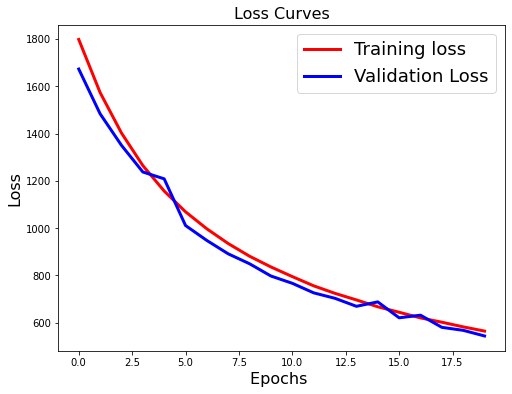

In [15]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

In [16]:
# Load data from x_dir, stop after loading fn_max files
# Returns X, Y, Dir
# X - independent variables
# Y - dependend variables (x-, y-, z- of the vertex in this implementation)
# Dir - direction vector (x-, y-, z- componenets), could be made dependent variable
def load_test_data_to_memory(x_dir, fn_max=2000) :
    X, Y, Dir = np.array([]), np.array([]), np.array([])
    f_list = os.listdir(x_dir)
    f_list.sort()
    i=0
    for x in f_list :
        batch_data = np.load(os.path.join(x_dir, x))
        
        X = np.vstack([X, np.array(batch_data['x'])]) if X.size else np.array(batch_data['x'])
        Y = np.vstack([Y, np.array(batch_data['y_vtx'])]) if Y.size else np.array(batch_data['y_vtx'])
        Dir = np.vstack([Dir, np.array(batch_data['y_dir'])]) if Dir.size else np.array(batch_data['y_dir'])

        i+=1
        if i%10 == 0:
            print(x)
            print('i = ', i, '   ', X.shape, '   ', Y.shape, '   ', Dir.shape)
        if i>=fn_max:
            break
    print(X.shape, '   ', Y.shape, '   ', Dir.shape)
    return X, Y, Dir

In [17]:
testX, testY, trueDir = load_test_data_to_memory('/data/Elagin/test_vtx_dir_1el_norm/',200)

f_batch_1008.npz
i =  10     (10000, 6300)     (10000, 3)     (10000, 3)
f_batch_1018.npz
i =  20     (20000, 6300)     (20000, 3)     (20000, 3)
f_batch_1028.npz
i =  30     (30000, 6300)     (30000, 3)     (30000, 3)
f_batch_1038.npz
i =  40     (40000, 6300)     (40000, 3)     (40000, 3)
f_batch_1048.npz
i =  50     (50000, 6300)     (50000, 3)     (50000, 3)
f_batch_1058.npz
i =  60     (60000, 6300)     (60000, 3)     (60000, 3)
(69000, 6300)     (69000, 3)     (69000, 3)


In [18]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)

dY = recoY - testY
dY0 = recoY[:,0] - testY[:,0]
dY1 = recoY[:,1] - testY[:,1]
dY2 = recoY[:,2] - testY[:,2]
dR = np.sqrt((recoY[:,0] - testY[:,0])*(recoY[:,0] - testY[:,0]) + (recoY[:,1] - testY[:,1])*(recoY[:,1] - testY[:,1]) + (recoY[:,2] - testY[:,2])*(recoY[:,2] - testY[:,2]) )
print(dR.shape, '  dR_mean = ', np.mean(dR))
R_true = np.sqrt(testY[:,0]*testY[:,0] + testY[:,1]*testY[:,1] + testY[:,2]*testY[:,2])
print(R_true.shape)
print(testY.shape)

print('dY: ',dY[0:3,:])
dRb = dR.reshape(dR.shape[0],1)
dY = dY/dRb
print('dY_norm: ',dY[0:3,:])
#np.random.shuffle(trueDir)
vtx_dot_dir = np.sum(dY*trueDir, axis=1)
print(vtx_dot_dir.shape)

shape recoY =  (69000, 3)    shape testY =  (69000, 3)
(69000,)   dR_mean =  20.402970570688073
(69000,)
(69000, 3)
dY:  [[  4.33024236  13.73921077   7.46309628]
 [ 30.31450834   7.64977865   2.41968857]
 [ 21.01998341   8.42326708 -14.72783162]]
dY_norm:  [[ 0.26690525  0.84685041  0.46000649]
 [ 0.9667138   0.24394744  0.0771626 ]
 [ 0.77814432  0.31182315 -0.54521349]]
(69000,)


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1155., 1297., 1426., 1524., 1632., 1852., 1972., 2219.,
        2436., 2763., 3061., 3332., 3655., 4100., 4494., 5213., 5665.,
        6292., 6994., 7918.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
        -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
         0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
         1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 [<matplotlib.patches.Polygon at 0x7ef8642cac70>])

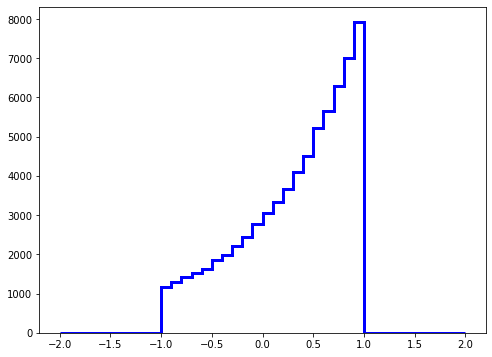

In [19]:
plt.figure(figsize=[8,6])
plt.hist(vtx_dot_dir, bins=40, range=(-2,2), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')

MSE =  181.42205708823994
MSE2 =  181.42205708823994
dY0_Mean_vtx =  -0.008952766712411235    dY1_Mean_vtx =  -0.5077530982267437    dY2_Mean_vtx =  0.03154532965962408
dY0_Rms_vtx =  18.395048380442713     dY1_Rms_vtx =  10.881733283917782     dY2_Rms_vtx =  9.352873733969023
resolution_vtx =  23.329512880999463
reco_Y1_vtx =  [102.13374 100.90491 -95.32291 ... -98.28656 157.60667 187.04158]
test_Y1_vtx =  [  88.39453251   93.25512858 -103.74617358 ...  -95.89908356  147.26501423
  174.45347208]
Mean_true_vtx_0 =  0.670034678007085    Mean_true_vtx_1 =  -0.5676216972889134 Mean_true_vtx_2 =  0.6261354391093403
RMS_true_vtx_0 =  134.53088806010035    RMS_true_vtx_1 =  134.04121142703264   RMS_true_vtx_2 =  134.17275749549958


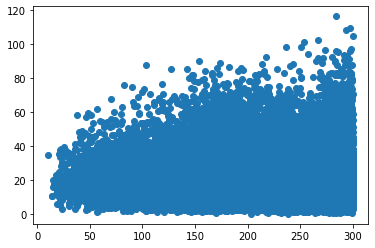

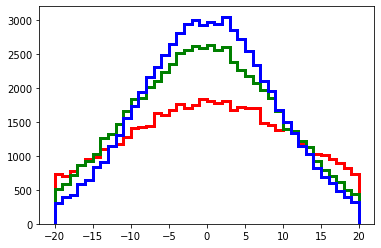

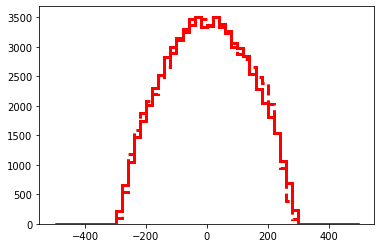

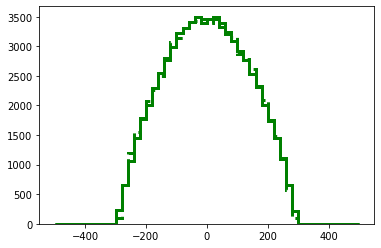

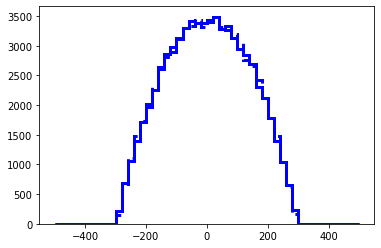

In [20]:
MSE = np.mean( (recoY.flatten()[:] - testY.flatten()[:])*(recoY.flatten()[:] - testY.flatten()[:]) )
print('MSE = ', MSE)

#MSE2 = np.mean(np.square(recoY - testY), axis=-1)
MSE2 = np.mean(np.square(recoY.flatten()[:] - testY.flatten()[:]), axis=-1)
print('MSE2 = ', MSE2)

#dTheta_dir = recoY[:,3] - testY[:,3]
#dPhi_dir = recoY[:,4] - testY[:,4]
print('dY0_Mean_vtx = ' ,np.mean(dY0), '   dY1_Mean_vtx = ', np.mean(dY1), '   dY2_Mean_vtx = ' ,np.mean(dY2))
print('dY0_Rms_vtx = ',np.sqrt(np.mean(np.square(dY0))), '    dY1_Rms_vtx = ',np.sqrt(np.mean(np.square(dY1))), '    dY2_Rms_vtx = ',np.sqrt(np.mean(np.square(dY2))))
print('resolution_vtx = ', np.sqrt(np.mean(np.square(dY0)) + np.mean(np.square(dY1)) + np.mean(np.square(dY2)) ) )
#print('ThetaMean_dir = ',np.mean(dTheta_dir),'   PhiMean_dir = ',np.mean(dPhi_dir))
#print('ThetaRms_dir = ',np.sqrt(np.mean(np.square(dTheta_dir))), '   PhiRms_dir = ',np.sqrt(np.mean(np.square(dPhi_dir))))

print('reco_Y1_vtx = ',recoY[:,1])
print('test_Y1_vtx = ',testY[:,1])


fig_scatt = plt.figure()
plt.scatter(R_true, dR)

fig_dYs = plt.figure()
plt.hist(dY0, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
plt.hist(dY1, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
plt.hist(dY2, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')

fig_Y0s = plt.figure()
plt.hist(recoY[:,0], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
fig_Y1s = plt.figure()
plt.hist(recoY[:,1], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
fig_Y2s = plt.figure()
plt.hist(recoY[:,2], bins=50, range=(-500,500), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'b')
plt.hist(testY[:,2], bins=50, range=(-500,500), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')

print('Mean_true_vtx_0 = ', np.mean(testY[:,0]), '   Mean_true_vtx_1 = ' , np.mean(testY[:,1]), 'Mean_true_vtx_2 = ', np.mean(testY[:,2]))
print('RMS_true_vtx_0 = ' , np.sqrt(np.mean(np.square(testY[:,0]))), '   RMS_true_vtx_1 = ' , np.sqrt(np.mean(np.square(testY[:,1]))), '  RMS_true_vtx_2 = ', np.sqrt(np.mean(np.square(testY[:,2]))) )